In [1]:



from __future__ import print_function 
import sys
import os
import argparse
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.autograd import Variable
from data import WIDERFace_ROOT , WIDERFace_CLASSES as labelmap
from PIL import Image
from data import WIDERFaceDetection, WIDERFaceAnnotationTransform, WIDERFace_CLASSES, WIDERFace_ROOT, BaseTransform , TestBaseTransform
from data import *
import torch.utils.data as data
from face_ssd import build_ssd
#from resnet50_ssd import build_sfd
import pdb
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import time

import torchvision


from utils.infer_utils import *


%load_ext autoreload
%autoreload 2

In [2]:
WIDERFace_CLASSES = ['face']
trained_model = './weights/WIDERFace_DSFD_RES152.pth'
cuda = True
img_root = './data/worlds-largest-selfie.jpg'
save_folder = 'eval_tools/'
visual_threshold = 0.1
IMG_Size = 640


if cuda and torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

## Make data loaders with and without resizing

In [3]:
transform_a = transforms.Compose([
    # you can add other transformations in this list
#     transforms.Resize((IMG_Size,IMG_Size)),
    transforms.ToTensor()
    
])

transform_b = transforms.Compose([
    # you can add other transformations in this list
    transforms.Resize((IMG_Size,IMG_Size)),
    transforms.ToTensor()
    
])

imagenet_data_a = torchvision.datasets.ImageNet('./data/ImageNet/', transform=transform_a)
data_loader_a = torch.utils.data.DataLoader(imagenet_data_a,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=8)

imagenet_data_b = torchvision.datasets.ImageNet('./data/ImageNet/', transform=transform_b)
data_loader_b = torch.utils.data.DataLoader(imagenet_data_b,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=8)

KeyboardInterrupt: 

torch.Size([3, 250, 250])


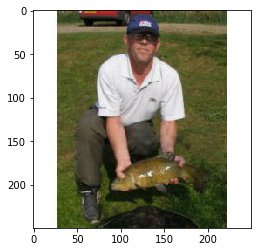

In [4]:
plt.imshow(data_loader_a.dataset[0][0].permute(1,2,0))
print(data_loader_a.dataset[0][0].shape)


## Load pretrained network (resnet152)

In [5]:
cfg = widerface_640
num_classes = len(WIDERFace_CLASSES) + 1 # +1 background
net = build_ssd('test', cfg['min_dim'], num_classes) # initialize SSD
net.load_state_dict(torch.load(trained_model))

if torch.cuda.device_count() > 1:  
    net = nn.DataParallel(net) #enabling data parallelism

net.cuda()

net.eval()
print('Finished loading model!')

loading pretrained resnet model
Finished loading model!


## Perform inference on an image

### Select Image

In [7]:
cuda = cuda
transform = TestBaseTransform((104, 117, 123))
thresh=cfg['conf_thresh']
img_id = 'face'

from_memory = True
data_loader = data_loader_a
img_num = 1

if from_memory:
    img_root = '../face-detection-project-prakash/img.jpg'
    img_root = 'data/worlds-largest-selfie.jpg'
    path = img_root
    img = cv2.imread(path, cv2.IMREAD_COLOR)
else: 
    img = data_loader.dataset[img_num][0].permute(1,2,0).numpy()
    img = img[:,:,::-1]*255



### Inference Code

In [8]:
# max_im_shrink = ( (2000.0*2000.0) / (img.shape[0] * img.shape[1])) ** 0.5
# shrink = max_im_shrink if max_im_shrink < 1 else 1



# det0 = infer(net , img , transform , thresh , cuda , shrink)
# det1 = infer_flip(net , img , transform , thresh , cuda , shrink)


# # shrink detecting and shrink only detect big face
# st = 0.5 if max_im_shrink >= 0.75 else 0.5 * max_im_shrink
# det_s = infer(net , img , transform , thresh , cuda , st)
# index = np.where(np.maximum(det_s[:, 2] - det_s[:, 0] + 1, det_s[:, 3] - det_s[:, 1] + 1) > 30)[0]
# det_s = det_s[index, :]


# # enlarge one times
# factor = 2
# bt = min(factor, max_im_shrink) if max_im_shrink > 1 else (st + max_im_shrink) / 2
# det_b = infer(net , img , transform , thresh , cuda , bt)


# # enlarge small iamge x times for small face
# if max_im_shrink > factor:
#     bt *= factor
#     while bt < max_im_shrink:
#         det_b = np.row_stack((det_b, infer(net , img , transform , thresh , cuda , bt)))
#         bt *= factor
#     det_b = np.row_stack((det_b, infer(net , img , transform , thresh , cuda , max_im_shrink) ))


    
# if bt > 1:
#     index = np.where(np.minimum(det_b[:, 2] - det_b[:, 0] + 1, det_b[:, 3] - det_b[:, 1] + 1) < 100)[0]
#     det_b = det_b[index, :]
# else:
#     index = np.where(np.maximum(det_b[:, 2] - det_b[:, 0] + 1, det_b[:, 3] - det_b[:, 1] + 1) > 30)[0]
#     det_b = det_b[index, :]

    
# det = np.row_stack((det0, det1, det_s, det_b))
det = det1
det = bbox_vote(det)

/home/suleman/anaconda/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/suleman/anaconda/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


### Visualize output

604


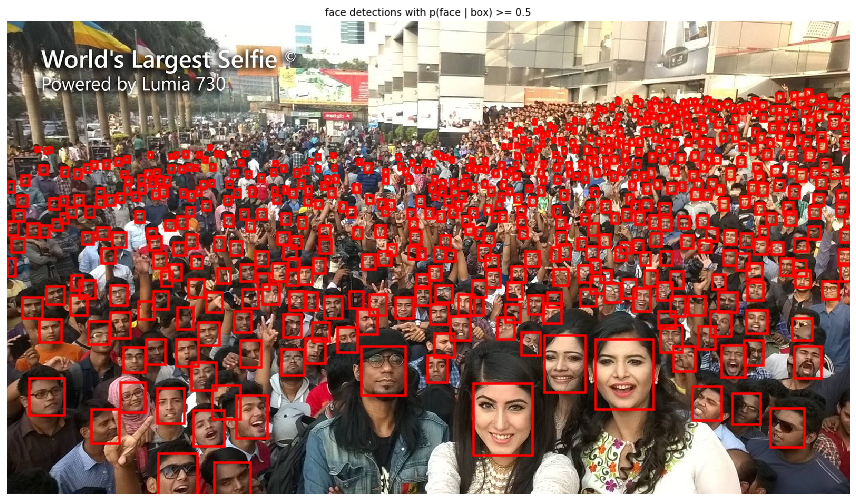

In [34]:
# det = det1
# det = np.row_stack((det0, det1))
# det = np.row_stack((det_b, det_s))
det = np.row_stack((det0, det1, det_b))
det = bbox_vote(det)
vis_detections(img.astype(np.int32) , det , img_id, 0.5, plot_only=True)

In [11]:
img_orig = data_loader_a.dataset[img_num][0].permute(1,2,0).numpy()
img_orig = img_orig[:,:,::-1]*255
scale = np.array(img_orig.shape[0:2])/IMG_Size
scale = np.tile(scale[::-1], 2)
print(scale)
det_mod = det.copy()
det_mod[:,:4] = det_mod[:,:4]*scale
print(det, det_mod)

[0.3125   0.234375 0.3125   0.234375]
[[1.65989661e+02 4.92823092e+01 2.64056533e+02 2.15998130e+02
  9.99938250e-01]
 [4.21968667e+02 4.10741478e+02 4.36180956e+02 4.30058088e+02
  2.28226066e-01]
 [4.88918991e+02 3.44273689e+02 5.54232665e+02 4.54543150e+02
  1.88217118e-01]
 ...
 [5.34268917e+02 1.73526118e+02 5.50109761e+02 1.91866122e+02
  1.11395484e-02]
 [4.55196339e+02 5.53178041e+02 4.76979053e+02 5.86351495e+02
  1.08422488e-02]
 [4.33560157e+02 5.67189822e+02 4.53556503e+02 5.90525645e+02
  1.08037619e-02]] [[5.18717691e+01 1.15505412e+01 8.25176666e+01 5.06245618e+01
  9.99938250e-01]
 [1.31865208e+02 9.62675338e+01 1.36306549e+02 1.00794864e+02
  2.28226066e-01]
 [1.52787185e+02 8.06891458e+01 1.73197708e+02 1.06533551e+02
  1.88217118e-01]
 ...
 [1.66959037e+02 4.06701840e+01 1.71909300e+02 4.49686223e+01
  1.11395484e-02]
 [1.42248856e+02 1.29651103e+02 1.49055954e+02 1.37426132e+02
  1.08422488e-02]
 [1.35487549e+02 1.32935115e+02 1.41736407e+02 1.38404448e+02
  1.08037

1


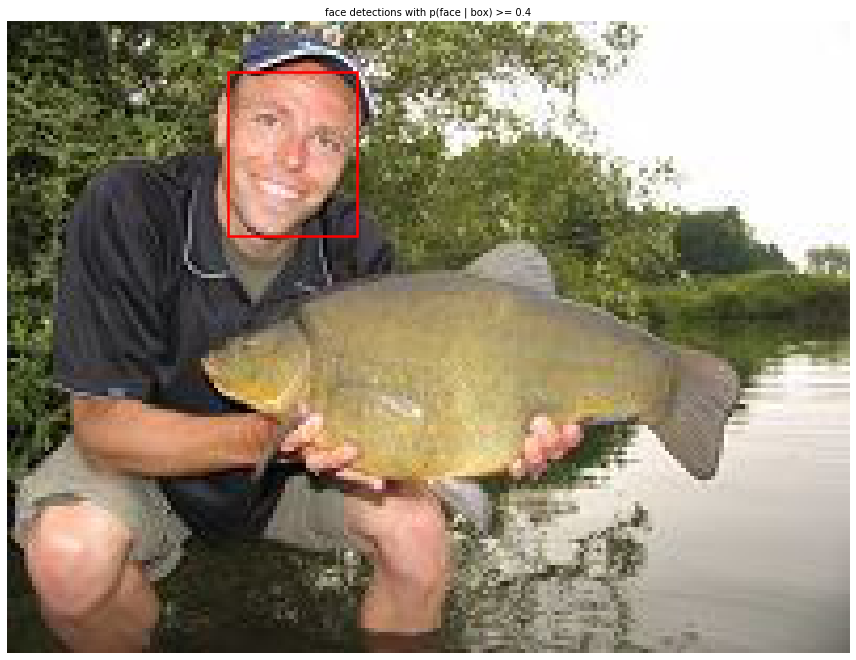

In [12]:
vis_detections(img_orig.astype(np.int32) , det_mod , img_id, 0.4, plot_only=True)

## Create Imagenet Shape Vector and Save it 
#### for fixing box sizes after inference

In [ ]:
shapes = []
for i, (im, _) in enumerate(data_loader_a.dataset):
    shapes.append(im.numpy().shape[1:])
#     print(shapes[i])
#     if i>10000:
#         break
shapes = np.array(shapes)
np.savetxt('imagenet_shapes_all.csv', shapes, fmt='%d',delimiter= ',')
print('Saved first 10000 image shapes')

In [21]:
mini = torch.utils.data.Subset(data_loader_a.dataset, )

SyntaxError: invalid syntax (<ipython-input-21-bf457632a1d3>, line 1)

In [ ]:
plt.imshow(data_loader.dataset[0][0].permute(1,2,0))
x = data_loader.dataset[0][0]
x = Variable(x.unsqueeze(0)).cuda()
print(data_loader.dataset[0][0].permute(1,2,0))

In [ ]:
y_t = net(x)

In [ ]:
detections = y_t.data

print(detections.shape)

In [ ]:
det = []
for i in range(detections.size(1)):
    j = 0
    while detections[0, i, j, 0] >= 0.1:
        score = detections[0, i, j, 0]
        score = score.cpu().numpy()
        #label_name = labelmap[i-1]
        pt = (detections[0, i, j, 1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1], pt[2], pt[3]) 
        det.append([pt[0], pt[1], pt[2], pt[3], score])
        j += 1
if (len(det)) == 0:
    det = [ [0.1,0.1,0.2,0.2,0.01] ]
det = np.array(det)

In [ ]:
chk_det = np.row_stack((det0, det1, det_s, det_b))

In [ ]:
chk_det.shape
order = chk_det[:, 4].ravel().argsort()[::-1]
print(order)

In [14]:
# print(img, data_loader.dataset[0][0])
# print(np.max(img))
# plt.imshow(img)
img.shape

(640, 640, 3)

In [9]:

with torch.no_grad():
    for idx, (x,y) in enumerate(data_loader_b):
        print(idx)
        if idx >3:
            break

AttributeError: 'DataLoader' object has no attribute 'to'

In [15]:

torch.cuda.set_device(1)
for i_batch, sample_batched in enumerate(data_loader_b):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

RuntimeError: Traceback (most recent call last):
  File "/home/suleman/anaconda/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 99, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/suleman/anaconda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 68, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/home/suleman/anaconda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 68, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/home/suleman/anaconda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 59, in default_collate
    return torch.tensor(batch)
RuntimeError: CUDA error: initialization error


In [16]:
dataiter = iter(data_loader)

In [18]:
dataiter.next()

RuntimeError: Traceback (most recent call last):
  File "/home/suleman/anaconda/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 99, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/suleman/anaconda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 68, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/home/suleman/anaconda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 68, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/home/suleman/anaconda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 59, in default_collate
    return torch.tensor(batch)
RuntimeError: CUDA error: initialization error
